# Проект: Анализ прибыльности регионов добычи нефти

**Описание проекта**

Компания планирует разработку 200 новых нефтяных скважин. Для выбора региона необходимо построить линейную модель, которая предскажет объём запасов в скважинах на основании предоставленных геологических данных. Далее требуется провести анализ прибыли и рисков, чтобы определить наиболее перспективный регион для инвестиций.


**Цель исследования**

Определить регион, в котором разработка 200 скважин принесёт наибольшую прибыль при допустимом уровне риска убытков.

**Ход исследования**

Для достижения поставленной цели будут выполнены следующие шаги:

- Первичный анализ и предобработка данных;
- Исследовательский анализ данных;
- Моделирование;
- Расчет прибыли.

Также в заключительной части проекта будут сформулированы итоговые выводы и рекомендации для заказчика.

## Настройка среды

In [1]:
# устанавливаем библиотеки
!pip install phik -q
!pip install shap -q

In [2]:
# обновляем библиотеки
!pip install -Uq scikit-learn

In [3]:
# импорт основных библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
# импорт функций для МО
from phik import phik_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Ознакомление с данными

Для проекта заказчик предоставил данные с признаками:

- **id** — уникальный идентификатор скважины;
- **f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы);
- **product** — объём запасов в скважине (тыс. баррелей).

In [5]:
# сохраняем датасеты в переменные
region_1 = pd.read_csv('geo_data_0.csv') # первый регион 
region_2 = pd.read_csv('geo_data_1.csv') # второй регион
region_3 = pd.read_csv('geo_data_2.csv') # третий регион

### region_1

In [6]:
# первые 10 строк
region_1.head(10)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


In [7]:
# общая информация
region_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
# размерность
print(f'Размерность: {region_1.shape[0]} строк, {region_1.shape[1]} столбцов')

Размерность: 100000 строк, 5 столбцов


In [9]:
# статистическое описание признаков
region_1.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


### region_2

In [10]:
# первые 10 строк
region_2.head(10)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


In [11]:
# общая информация
region_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [12]:
# размерность
print(f'Размерность: {region_2.shape[0]} строк, {region_2.shape[1]} столбцов')

Размерность: 100000 строк, 5 столбцов


In [13]:
# статистическое описание признаков
region_2.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


### region_3

In [14]:
# первые 10 строк
region_3.head(10)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


In [15]:
# общая информация
region_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [16]:
# размерность
print(f'Размерность: {region_3.shape[0]} строк, {region_3.shape[1]} столбцов')

Размерность: 100000 строк, 5 столбцов


In [17]:
# статистическое описание признаков
region_3.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


<div style="border: 2px solid black; padding: 10px;">
  <strong>На этапе предобработки требуется:</strong>
  <ul> 
    <li>Проверить датафреймы на наличие явных дубликатов и устранить их;</li> 
    <li>Проверить датафреймы на наличие пропусков и устранить их;</li>
    <li>Проверить тип данных столбцов;</li> 
    <li>Проверить данные на наличие ошибок и устранить их;</li> 
    <li>Статистическое описание указывает на наличие выбросов, которые необходимо более детально исследовать на этапе EDA.</li>  
      
  После предобработки данные будут пригодны для дальнейшего анализа.  
  </ul>
</div>

## Предобработка данных

### Обработка дубликатов

Проверим, есть ли дубли в единственном категориальном признаке **id**:

In [18]:
# проверяем наличие дублей в id
print('Дублирующиеся id в region_1:')
print(region_1.id.value_counts().head(5))
print('---------------------------------')

print('Дублирующиеся id в region_2:')
print(region_2.id.value_counts().head(5))
print('---------------------------------')

print('Дублирующиеся id в region_3:')
print(region_3.id.value_counts().head(5))
print('---------------------------------')

Дублирующиеся id в region_1:
id
fiKDv    2
QcMuo    2
AGS9W    2
Tdehs    2
74z30    2
Name: count, dtype: int64
---------------------------------
Дублирующиеся id в region_2:
id
wt4Uk    2
LHZR0    2
5ltQ6    2
bfPNe    2
kBEdx    1
Name: count, dtype: int64
---------------------------------
Дублирующиеся id в region_3:
id
VF7Jo    2
KUPhW    2
xCHr8    2
Vcm5J    2
fwXo0    1
Name: count, dtype: int64
---------------------------------


Да, такие дубли есть во всех датафреймах. Возможно причина в синтетической природе данных или неоднократных замерах одной и той же скважины (например, в разное время или с разными приборами).

Дублирующиеся id сами по себе не мешают построению модели, потому что для обучения мы будем использовать признаки f0, f1, f2 и целевой product. Так что неинформативный признак id есть смысл уже сейчас сделать индексом:

In [19]:
# переводим id в индекс
region_1.set_index('id', inplace=True)
region_2.set_index('id', inplace=True)
region_3.set_index('id', inplace=True)

# проверим изменения
region_1.head(5)

,f0,f1,f2,product
id,,,,
txEyH,0.705745,-0.497823,1.221170,105.280062
2acmU,1.334711,-0.340164,4.365080,73.037750
409Wp,1.022732,0.151990,1.419926,85.265647
iJLyR,-0.032172,0.139033,2.978566,168.620776
Xdl7t,1.988431,0.155413,4.751769,154.036647


Теперь проверяем датафреймы на наличие явных дубликатов:

In [20]:
# проверяем данные на наличие явных дубликатов
print(f"Количество явных дубликатов в region_1: {region_1.duplicated().sum()}")
print(f"Количество явных дубликатов в region_2: {region_2.duplicated().sum()}")
print(f"Количество явных дубликатов в region_3: {region_3.duplicated().sum()}")

Количество явных дубликатов в region_1: 0
Количество явных дубликатов в region_2: 0
Количество явных дубликатов в region_3: 0


Явные дубликаты отсутствуют.

### Обработка пропусков

Проверим датафреймы на наличие пропусков:

In [21]:
# проверяем количество пропусков в данных
region_1.isna().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64

In [22]:
region_2.isna().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64

In [23]:
region_3.isna().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64

Пропуски отсутствуют.

### Изменение типов данных

Проверим, корректны ли типы данных:

In [24]:
# проверяем типы данных
region_1.dtypes

f0         float64
f1         float64
f2         float64
product    float64
dtype: object

In [25]:
region_2.dtypes

f0         float64
f1         float64
f2         float64
product    float64
dtype: object

In [26]:
region_3.dtypes

f0         float64
f1         float64
f2         float64
product    float64
dtype: object

Все корректно, изменение типов данных не требуется.

<div style="border: 2px solid black; padding: 10px;">
  <strong>Итог:</strong>
  <ul>
В процессе предобработки было только одно изменение: неинформативный признак id переведен в индекс в каждом из датафреймов. Данные проверены и готовы к исследовательскому анализу.  
  </ul>
</div>

## Исследовательский анализ данных

Напишем функции для построения графиков:

In [27]:
# функция для построения распределений и боксплотов 
def plot_distribution(num_features, df, df_name):
    """
    Строит распределения и боксплоты для количественных признаков датафрейма.
    
    Параметры:
    - num_features: list of str, список количественных признаков
    - df: pd.DataFrame, датафрейм
    - df_name: str, имя датафрейма
    """
    n = len(num_features)
    fig, axes = plt.subplots(n, 2, figsize=(10, 4*n))
    
    for i, feat in enumerate(num_features):
        # распределение (гистограмма + kde)
        sns.histplot(df[feat], kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'{df_name}: Распределение признака {feat}')
        
        # боксплот
        sns.boxplot(y=df[feat], ax=axes[i, 1])
        axes[i, 1].set_title(f'{df_name}: Boxplot признака {feat}')
    
    plt.tight_layout()
    plt.show()

In [28]:
# функция для построения матрицы корреляций
def plot_corr_heatmap(corr, df_name):
    """
    Строит heatmap для матрицы корреляций.
    
    Параметры:
    - corr: pd.DataFrame или np.array, матрица корреляций между признаками
    - df_name: str, имя датафрейма
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f"Матрица корреляций {df_name}")
    
    plt.show()

### Распределение признаков

На данном этапе мы проведем статистический анализ всех признаков, а также построим графики для каждого из них. Это поможет заметить выбросы, необычное распределение и другие особенности с целью улучшить данные и подготовить их к моделированию.

Исследуем количественные признаки:

In [29]:
# статистическое описание количественных признаков region_1
region_1.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


**Анализ статистического описания region_1:**

- **f0**: Значения распределены в пределах от -1.4 до 2.4, среднее и медиана совпадают (=0.5). Разброс умеренный, сильных экстремальных значений нет.
- **f1**: Более «узкий» признак, значения от -0.85 до 1.34, среднее и медиана совпадают (≈0.25). Вариативность меньше, чем у f0.
- **f2**: Сильно отличается от первых двух признаков — широкий диапазон от -12 до 16 и большое стандартное отклонение (≈3.25). Есть выраженные крайние значения.
- **product**: Целевой признак варьируется от 0 до 185, среднее (92.5) и медиана (91.8) близки, но разброс очень высокий (ст.отклонение ≈44), что указывает на значительную неоднородность скважин.

In [30]:
# статистическое описание количественных признаков region_2
region_2.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


**Анализ статистического описания region_2:**

- **f0**: Среднее и медиана очень близки (1.14-1.15), разброс очень высокий (ст.отклонение ≈9), диапазон широкий (от -31.6 до 29.4), возможно есть выбросы.
- **f1**: Среднее и медиана совпадают (-4.8), разброс значительный (ст.отклонение ≈5.1), диапазон от -26.4 до 18.7, распределение смещено в отрицательную область.
- **f2**: Среднее - 2.5, медиана - 2.0, разброс умеренный (≈1.7), значения в основном в пределах от 0 до 5.
- **product**: Среднее - 68.8, медиана - 57.1, разброс большой (≈46), диапазон от 0 до 138.

In [31]:
# статистическое описание количественных признаков region_3
region_3.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


**Анализ статистического описания region_3:**

- **f0**: Среднее и медиана равны нулю, разброс ощутимый (≈1.7), диапазон от -8.8 до 7.2, значения распределены симметрично вокруг нуля.
- **f1**: Среднее и медиана равны нулю, разброс аналогичный (≈1.7), диапазон от -7.1 до 7.8, структура похожа на f0.
- **f2**: Среднее и медиана равны 2.5, разброс высокий (≈3.5), диапазон широкий (от -12.0 до 16.7), скорее всего  в признаках f0-f2 присутствуют выбросы.
- **product**: Cреднее и медиана близки к 95, разброс значительный (≈44.7), значения от 0 до 190.

Теперь построим графики распределений и боксплотов для данных по каждому из регионов:

In [32]:
# данные для построения графиков
regions = [region_1, region_2, region_3]
region_names = ['region_1', 'region_2', 'region_3']
num_features = ['f0', 'f1', 'f2', 'product']

#### region_1

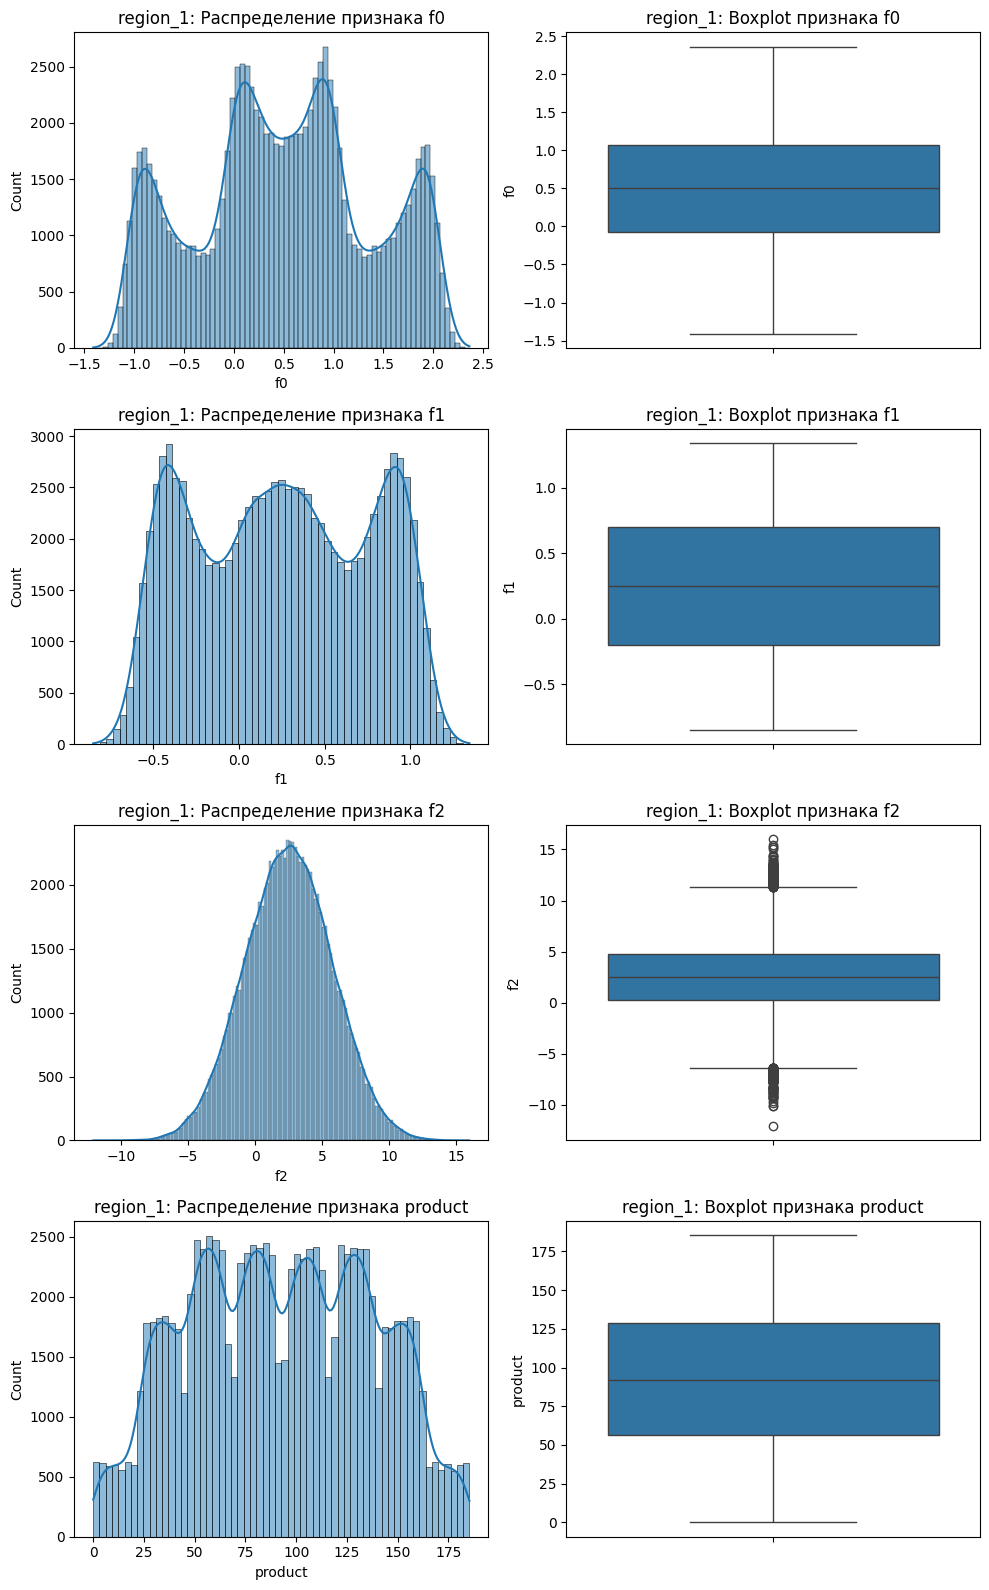

In [33]:
# построим распределения и боксплоты для region_1
plot_distribution(num_features, region_1, 'region_1')

<div style="border: 2px solid black; padding: 10px;">
  <strong>Наблюдения по количественным признакам region_1:</strong>
  <ul> 
    <li><strong>f0:</strong> Имеет мультимодальное распределение с четырьмя основными группами значений. Несмотря на сложную форму распределения, центральная половина данных (от 0.0 до 1.0) сгруппирована вокруг медианы 0.5. Разброс данных умеренный, выбросов не наблюдается.</li>
    <li><strong>f1:</strong> Распределение признака является мультимодальным, характеризующимся двумя доминирующими пиками (около -0.5 и 1.0), а также заметным, но менее выраженным, третьим скоплением данных в центральной части. Выбросы отсутствуют.</li>
    <li><strong>f2:</strong> Распределение близко к нормальному и выглядит достаточно симметричным относительно своего центра (3.0). Выбросы есть, но они не искажают общую картину.</li> 
    <li><strong>product:</strong> Распределение мультимодальное (6 мод), что, вероятно, указывает на то, что объем запасов присваивается из ограниченного набора стандартных значений или классов, выбросов нет. Эта информация важна для дальнейшего моделирования.</li>
  </ul>
</div>

#### region_2

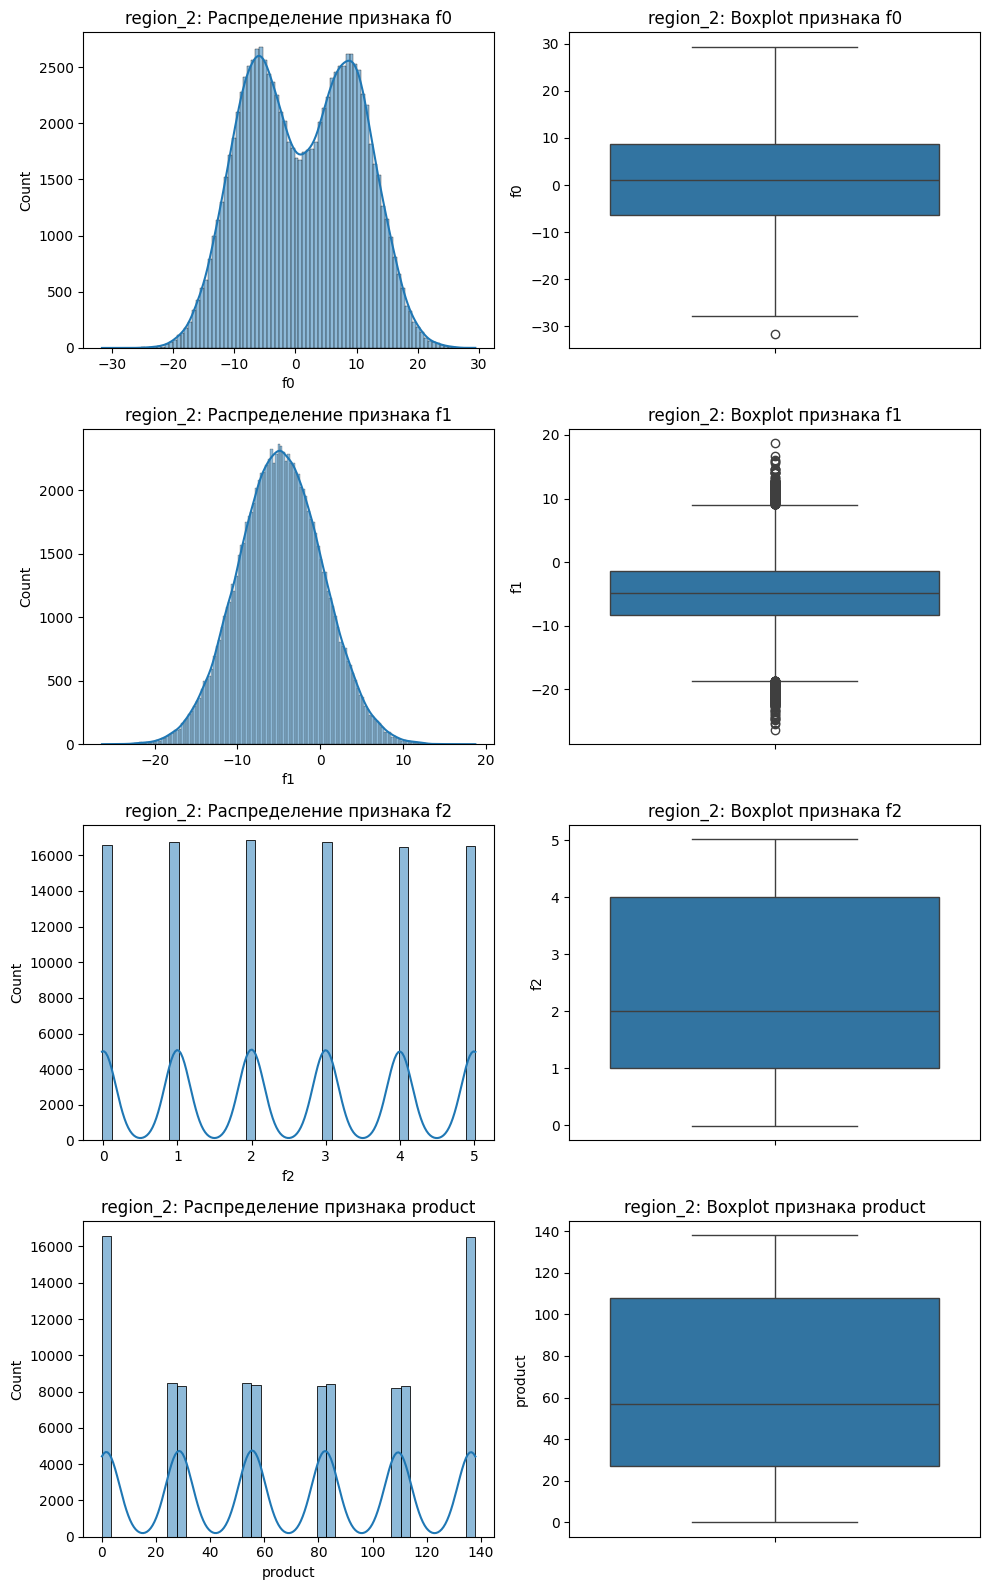

In [34]:
# построим распределения и боксплоты для region_2
plot_distribution(num_features, region_2, 'region_2')

<div style="border: 2px solid black; padding: 10px;">
  <strong>Наблюдения по количественным признакам region_2:</strong>
  <ul> 
    <li><strong>f0:</strong> Имеет выраженное бимодальное распределение, центрированное вокруг нуля. Присутствует один незначительный выброс в отрицательную сторону.</li>
    <li><strong>f1:</strong> Имеет распределение, которое близко к нормальному, но центрировано на отрицательном значении (около −5). Присутствуют выбросы с обеих сторон, но они не меняют существенно общую форму распределения.</li>
    <li><strong>f2:</strong> Признак имеет критически важную характеристику - он близок к дискретному и принимает значения, сгруппированные вокруг целых чисел от 0 до 5 с почти равномерной частотой, выбросов нет.</li> 
    <li><strong>product:</strong> Целевой признак тоже близок к дискретному с очень четкой структурой - видим шесть классов, два из которых (0 и 140) являются доминирующими, выбросов нет.</li>
  </ul>
</div>

#### region_3

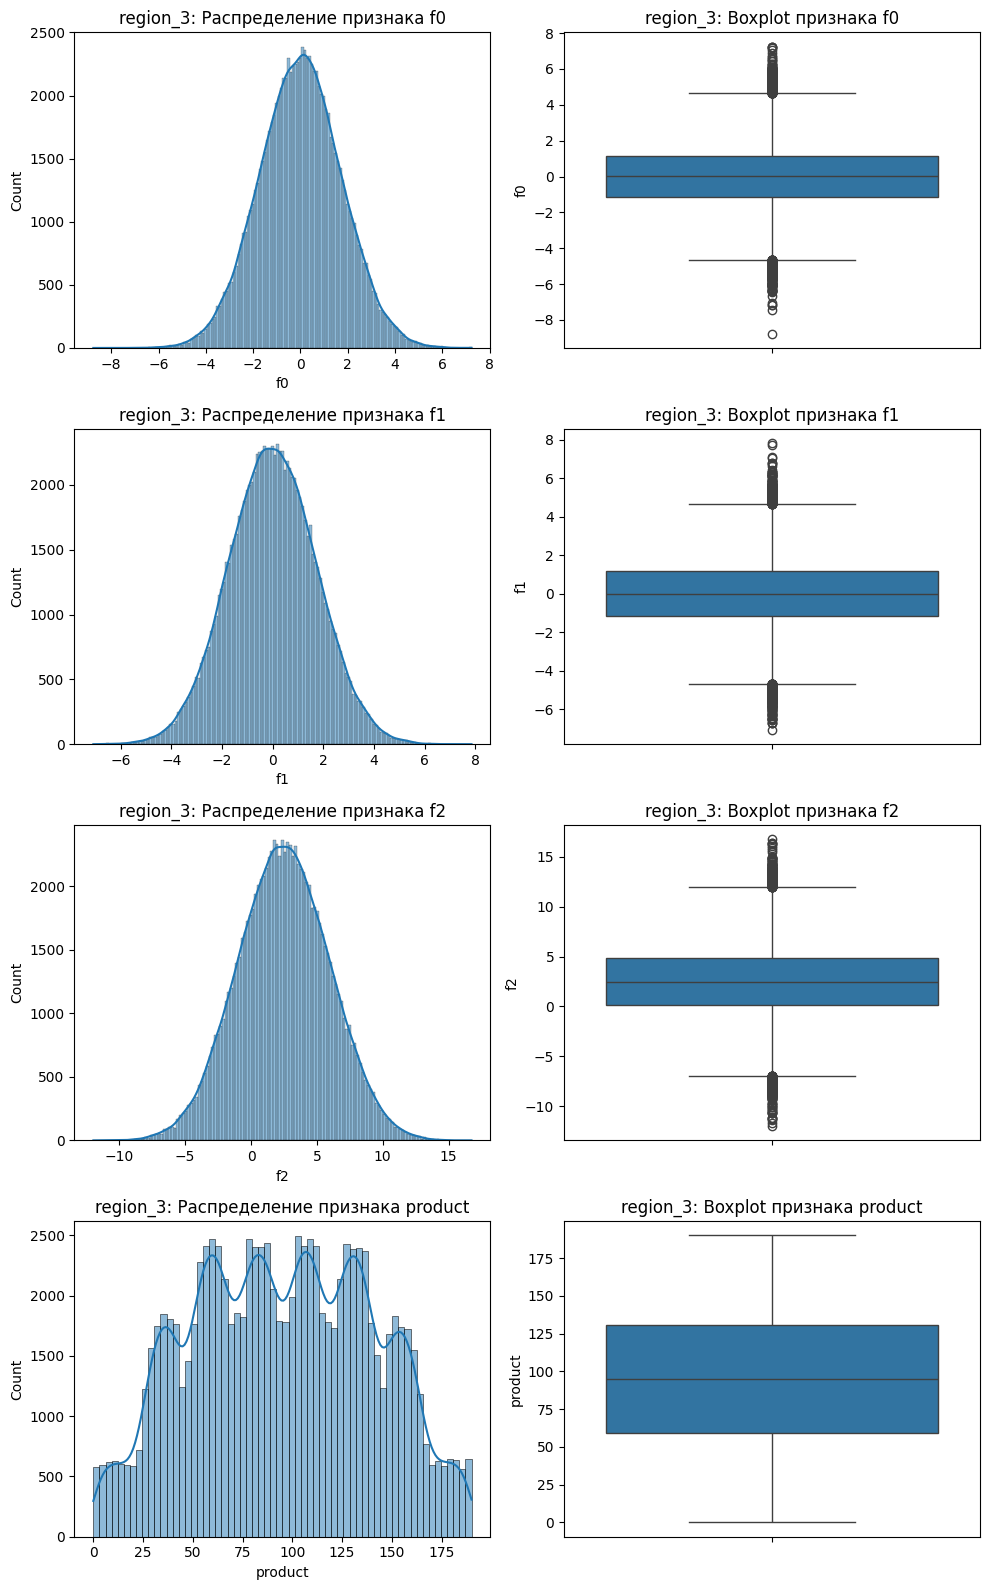

In [35]:
# построим распределения и боксплоты для region_3
plot_distribution(num_features, region_3, 'region_3')

<div style="border: 2px solid black; padding: 10px;">
  <strong>Наблюдения по количественным признакам region_3:</strong>
  <ul> 
    <li><strong>f0:</strong> Имеет распределение, которое близко к стандартному нормальному распределению (хотя и с небольшим сдвигом медианы от нуля и присутствием выбросов). Эта форма распределения является наиболее благоприятной для модели линейной регрессии.</li>
    <li><strong>f1:</strong> Имеет унимодальное распределение, идеально приближенное к нормальному, центрированное на нуле. Наличие выбросов не искажает распределение.</li>
    <li><strong>f2:</strong> Имеет унимодальное распределение, которое достаточно симметрично относительно своего центра (≈2.5, выбросы не искажают картину.</li> 
    <li><strong>product:</strong> Целевой признак в region_3 имеет структуру распределения, почти идентичную region_1 - мультимодальное распределение с несколькими пиками по всему диапазону. Таким образом, для моделирования в регионе 3, как и в остальных, следует ожидать, что модель будет предсказывать одно из нескольких дискретных значений.</li>
  </ul>
</div>

### Корреляционный анализ

На данном этапе мы изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между ними, построим диаграммы рассеяния и проанализируем корреляции.

На этапе исследовательского анализа мы заметили, что не все признаки распределены нормально, поэтому необходимо использовать подходы, которые устойчивы к выбросам, ненормальному распределению и дискретной природе признаков. Для этого построим матрицу корреляций по коэффициенту Phik:

#### region_1

In [36]:
# вычисляем phik корреляции, передав параметру interval_cols непрерывные количественные признаки
phik_corr_1 = region_1.phik_matrix(interval_cols=num_features)

phik_corr_1

,f0,f1,f2,product
f0,1.000000,0.762170,0.000000,0.215525
f1,0.762170,1.000000,0.000000,0.253544
f2,0.000000,0.000000,1.000000,0.475901
product,0.215525,0.253544,0.475901,1.000000


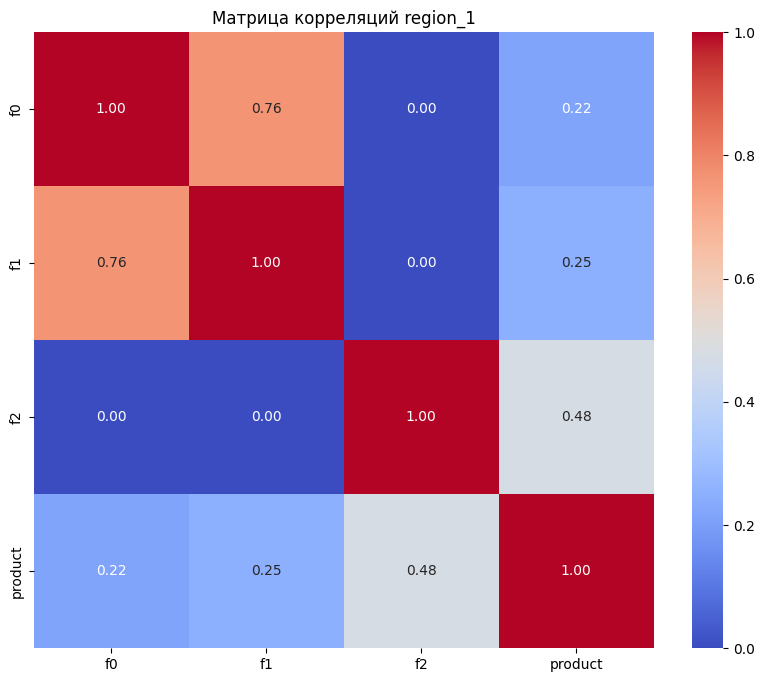

In [37]:
# визуализируем
plot_corr_heatmap(phik_corr_1, 'region_1')

<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы по корреляции с целевым признаком (product):</strong>
  <ul>
    <li><strong>f2 (0.48):</strong> Умеренная корреляция, выраженной зависимости нет.</li>
    <li><strong>f1 (0.25) и f0 (0.22):</strong> Имеют совсем слабую связь с целевым признаком.</li>    
  </ul>
</div>

<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы по корреляции признаков между собой:</strong>
  <ul>
    <li><strong>f0 и f1 (0.76):</strong> Высокая корреляция, но не слишком, чтобы пришлось устранять мультиколлинеарность.</li>
    <li><strong>Независимость f2:</strong> Признак f2 не зависит ни от f0, ни от f1.</li> 
    <li><strong>Корреляция ниже 0.95 редко приводит к эффектам мультиколлинеарности.</strong> К тому же в моделях есть регуляризации, которые борятся с мультиколлинеарностью и при более экстремальных показателях корреляции.</li>  
  </ul>
</div>

#### region_2

In [38]:
# вычисляем phik корреляции, передав параметру interval_cols количественные непрерывные признаки
phik_corr_2 = region_2.phik_matrix(interval_cols=num_features)

phik_corr_2

,f0,f1,f2,product
f0,1.000000,0.196080,0.000000,0.628482
f1,0.196080,1.000000,0.000000,0.185965
f2,0.000000,0.000000,1.000000,0.978936
product,0.628482,0.185965,0.978936,1.000000


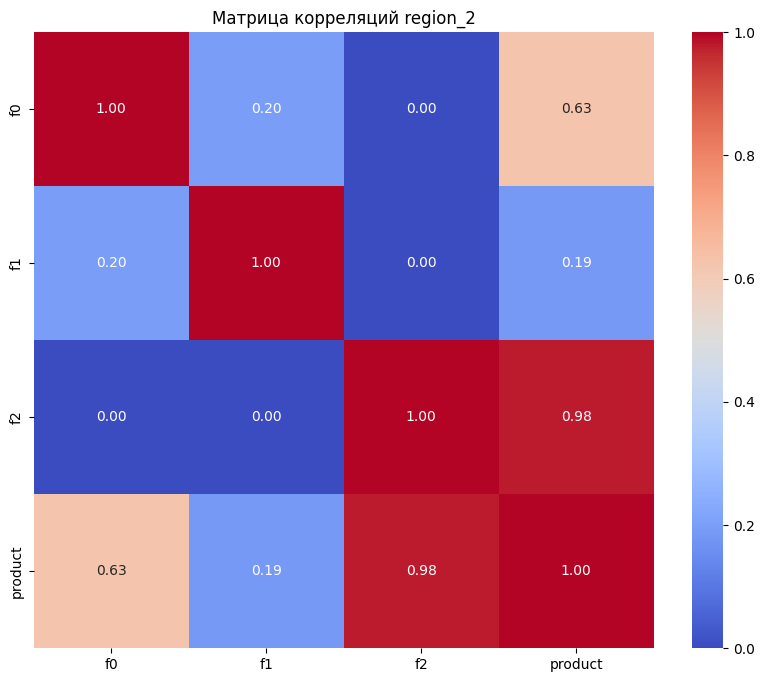

In [39]:
# визуализируем
plot_corr_heatmap(phik_corr_2, 'region_2')

<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы по корреляции с целевым признаком (product):</strong>
  <ul>
    <li><strong>f2 (0.98):</strong> Имеет почти идеальную связь с целевым признаком. Это означает, что f2 практически полностью определяет, к какому классу запасов, которые мы видели на гистограмме, относится скважина.</li>
    <li><strong>f0 (0.63):</strong> Также демонстрирует заметную связь.</li>  
    <li><strong>f1 (0.19):</strong> Имеет очень слабую связь с целевым признаком и, вероятно, не принесет существенной пользы модели.</li>  
  </ul>
</div>

<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы по корреляции признаков между собой:</strong>
  <ul>
    <li><strong>Низкая связь:</strong> Корреляция между всеми предикторами очень низкая (0.20), а связь f2 с остальными признаками вовсе отсутствует (0.00).</li>
    <li>В этом регионе <strong>мультиколлинеарность не является проблемой</strong>. Все три признака несут уникальную, не дублирующую информацию.</li>    
  </ul>
</div>

#### region_3

In [40]:
# вычисляем phik корреляции, передав параметру interval_cols количественные признаки
phik_corr_3 = region_3.phik_matrix(interval_cols=num_features)

phik_corr_3

,f0,f1,f2,product
f0,1.000000,0.000000,0.000000,0.201068
f1,0.000000,1.000000,0.000000,0.221022
f2,0.000000,0.000000,1.000000,0.443287
product,0.201068,0.221022,0.443287,1.000000


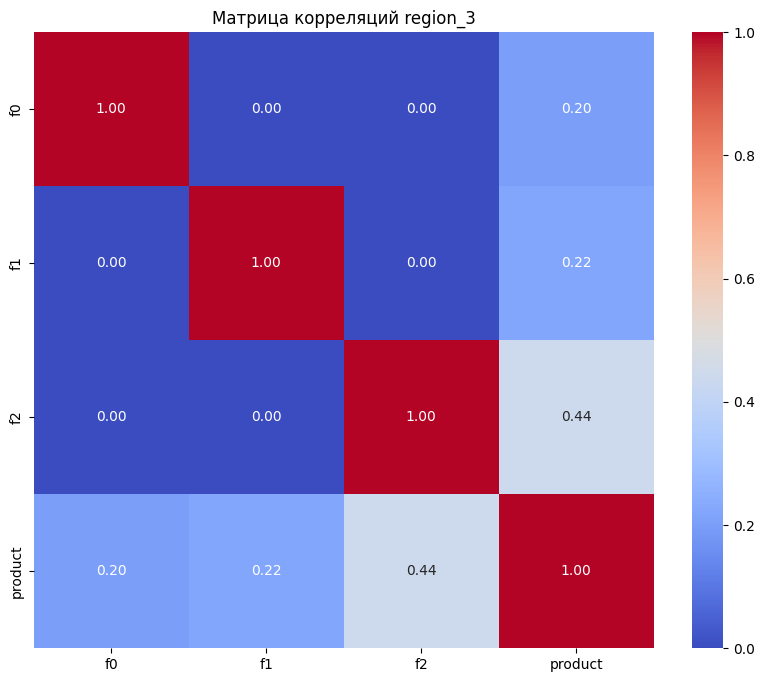

In [41]:
# визуализируем
plot_corr_heatmap(phik_corr_3, 'region_3')

<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы по корреляции с целевым признаком (product):</strong>
  <ul>
    <li><strong>f2 (0.44):</strong> Признак снова является самым сильным предиктором для целевого, но в данном случае корреляция все равно умеренная.</li>
    <li><strong>f1 (0.22) и f0 (0.20):</strong> Связь f0 и f1 с объемами запасов очень слабая.</li>    
  </ul>
</div>

<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы по корреляции признаков между собой:</strong>
  <ul>
    <li><strong>Независимость признаков:</strong> Все три признака (f0, f1, f2) абсолютно независимы друг от друга (0.00).</li>
    <li><strong>Мультиколлинеарность отсутствует:</strong> Все предикторы вносят в модель уникальную информацию, что является идеальным сценарием для обучения.</li> 
  </ul>
</div>

## Обучение моделей

Для удобства напишем функцию, которая объединит основные этапы моделирования:
 - Разбиение данных на обучающую и валидационную выборки в соотношении 75:25;
 - Обучение модели и получение предсказаний на валидационной выборке;
 - Сохранение предсказаний и правильных ответов на валидационной выборке;
 - Вывод на экран среднего запаса предсказанного сырья и RMSE модели.

In [42]:
# напишем функцию для подготовки данных и обучения 
def train_and_evaluate(df, df_name, feature_cols=['f0','f1','f2'], target_col='product', scale=True):
    # делим данные на обучающую и валидационную выборки
    X = df[feature_cols]
    y = df[target_col]
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.25, random_state=42)

    # масштабирование
    scaler = None
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

    # обучение модели
    model = LinearRegression()
    model.fit(X_train, y_train)

    # предсказания
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    # метрики
    mean_pred_val = y_pred_val.mean()
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))

    print(f'Регион: {df_name}')
    print(f'Средний предсказанный запас (val): {mean_pred_val:.2f}')
    print(f'RMSE (train):                      {rmse_train:.2f}')
    print(f'RMSE (val):                        {rmse_val:.2f}')

    # собираем датафрейм с результатами
    val_results = pd.DataFrame({
        "y_true": y_val,
        "y_pred": y_pred_val
    }, index=y_val.index)

    return val_results, model, scaler, mean_pred_val

Теперь применим функцию к данным по каждому из регионов и проанализируем результаты:

In [43]:
# результаты для первого региона
val_results_1, model_1, scaler_1, mean_pred_1 = train_and_evaluate(region_1, 'region_1')

Регион: region_1
Средний предсказанный запас (val): 92.40
RMSE (train):                      37.67
RMSE (val):                        37.76


/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280:

In [44]:
# результаты для второго региона
val_results_2, model_2, scaler_2, mean_pred_2 = train_and_evaluate(region_2, 'region_2')

Регион: region_2
Средний предсказанный запас (val): 68.71
RMSE (train):                      0.89
RMSE (val):                        0.89


/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280:

In [45]:
# результаты для третьего региона
val_results_3, model_3, scaler_3, mean_pred_3 = train_and_evaluate(region_3, 'region_3')

Регион: region_3
Средний предсказанный запас (val): 94.77
RMSE (train):                      40.03
RMSE (val):                        40.15


/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/linear_model/_base.py:280:

<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы по результатам для каждого региона:</strong>
  <ul>
    <li><strong>region_1:</strong> Средний предсказанный запас очень близок к описанному среднему (~92.5). Ошибка относительно среднего запаса составляет почти 40%, что типично для синтетических данных с нестандартным распределением. В целом, модель обучается нормально, но есть умеренные расхождения в предсказаниях отдельных скважин.</li>
    <li><strong>region_2:</strong> Средний предсказанный запас очень близок к описанному среднему (~68.8). По RMSE видно, что признаки сильно скоррелированы с таргетом, почти идеальная линейная зависимость. В EDA видно, что f2 и product имеют phik-корреляцию 0.978 — почти прямая линейная связь, отсюда почти идеальное предсказание.</li>
    <li><strong>region_3:</strong> Средний предсказанный запас очень близок к описанному среднему (~95). Ошибка около 40% от среднего, аналогично region_1. Модель относительно хорошо предсказывает, но разброс отдельных скважин значительный — вероятно, из-за выбросов или слабой линейной зависимости с признаками.</li>  
  </ul>
</div>

<div style="border: 2px solid black; padding: 10px;">
  <strong>Общие наблюдения:</strong>
  <ul>
    <li>Модель линейной регрессии предсказывает среднее значение верно для всех регионов.</li>
    <li>Точность сильно зависит от корреляции признаков с таргетом: чем сильнее линейная связь, тем меньше RMSE (как в region_2).</li>
    <li>Расхождение между train и val невелико, что указывает на отсутствие переобучения.</li>  
  </ul>
</div>

## Расчет прибыли

### Подготовка к расчету прибыли

Подготовимся к расчёту прибыли:
- Сохраним все ключевые значения для расчётов в отдельных переменных;
- Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины и сравним полученный объём сырья со средним запасом в каждом регионе; 
- Напишем выводы по этапу подготовки расчёта прибыли.

In [46]:
# ключевые значения для расчетов
BUDGET = 10_000_000_000    # бюджет на разработку региона (руб.)
UNIT_PRICE = 450_000       # руб. за 1 тыс. баррелей
WELLS_TO_DEVELOP = 200     # число скважин для разработки

Рассчитываем достаточный объём сырья для безубыточной разработки одной скважины:

In [47]:
budget_per_well = BUDGET / WELLS_TO_DEVELOP # доля бюджета на скважину
min_volume = budget_per_well / UNIT_PRICE   # расчет достаточного объема

print(f'Достаточный объём сырья для безубыточной разработки одной скважины: {min_volume:.2f} тыс. баррелей')

Достаточный объём сырья для безубыточной разработки одной скважины: 111.11 тыс. баррелей


Сравним полученный объём сырья со средним запасом в каждом регионе:

In [48]:
# формируем датафрейм
df_profit_check = pd.DataFrame({
    "Средний предсказанный запас": {"region_1": mean_pred_1, "region_2": mean_pred_2, "region_3": mean_pred_3},
    "Безубыточный объём": 111.11})

# добавим столбец с пометкой о риске
df_profit_check["Примечание"] = df_profit_check["Средний предсказанный запас"].apply(
    lambda x: "Ниже безубыточного - риск убытка" if x < min_volume else "Выше безубыточного - потенциально прибыльно")

df_profit_check

,Средний предсказанный запас,Безубыточный объём,Примечание
region_1,92.398800,111.11,Ниже безубыточного - риск убытка
region_2,68.712878,111.11,Ниже безубыточного - риск убытка
region_3,94.771024,111.11,Ниже безубыточного - риск убытка


<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы по этапу подготовки к расчету прибыли:</strong>
  <ul>
    <li>Безубыточный объём сырья на одну скважину (111.11 тыс. баррелей) превышает средние запасы всех трёх регионов.</li>
    <li>На основании средних значений ни один регион гарантированно не безубыточен, что означает, что при оценке рисков важна выборка 200 лучших скважин.</li>
    <li>Необходимо использовать предсказания модели, чтобы выбрать топ-200 скважин по каждому региону и оценить потенциальную прибыль и вероятность убытка.</li>  
  </ul>
</div>

### Функция для расчета прибыли

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели. Функция будет включать:
- Выбор скважины с максимальными значениями предсказаний; 
- Суммирование целевого значения объёма сырья, которое соответствует этим предсказаниям;
- Расчет прибыли для полученного объёма сырья.

In [49]:
# функция для расчёта прибыли по выбранным скважинам
def calculate_profit(val_results, top_n=WELLS_TO_DEVELOP, unit_price=UNIT_PRICE, budget=BUDGET):

    # выбираем скважины с максимальными предсказаниями
    top_wells = val_results.sort_values(by='y_pred', ascending=False).head(top_n)
    
    # суммарный объём реального сырья
    total_volume = top_wells['y_true'].sum()
    
    # расчёт прибыли
    revenue = total_volume * unit_price
    profit = revenue - budget
    
    return total_volume, profit, top_wells

### Подсчет рисков и прибыли

Теперь посчитаем риски и прибыль для каждого региона. Для этого:
- Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли;
- Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков;
- Проанализируем результаты и предложим регион для разработки скважин.

In [50]:
# bootstrap-функция для подсчета прибыли, ДИ и риска убытков
state = np.random.RandomState(12345)

def bootstrap_analysis(val_results):
    profits = []
    risks = []
    
    for _ in range(1000):
        # берём случайную выборку из 500 скважин с возвращением
        sample = val_results.sample(n=500, replace=True, random_state=state)
        
        # рассчитываем прибыль по топ-200 скважин
        _, profit, _ = calculate_profit(sample, top_n=WELLS_TO_DEVELOP, unit_price=UNIT_PRICE, budget=BUDGET)
        profits.append(profit)
        
        # риск: 1 если убыток, 0 если прибыль
        risks.append(1 if profit < 0 else 0)
    
    profits = pd.Series(profits)
    mean_profit = round(profits.mean(), 2)
    ci_lower = round(profits.quantile(0.025), 2)
    ci_upper = round(profits.quantile(0.975), 2)
    risk = round(pd.Series(risks).mean() * 100, 2)
    
    return mean_profit, ci_lower, ci_upper, risk

In [51]:
# выводим результаты для каждого региона
regions = {
    "region_1": val_results_1,
    "region_2": val_results_2,
    "region_3": val_results_3
}

for region_name, val_results in regions.items():
    mean_profit, ci_lower, ci_upper, risk = bootstrap_analysis(val_results)
    print(f"Регион: {region_name}")
    print(f"Средняя прибыль: {mean_profit:,.0f} руб.")
    print(f"95% доверительный интервал: {ci_lower:,.0f} — {ci_upper:,.0f} руб.")
    print(f"Риск убытков: {risk:.2f}%")
    print("-"*62)

Регион: region_1
Средняя прибыль: 406,278,783 руб.
95% доверительный интервал: -117,742,136 — 911,737,051 руб.
Риск убытков: 6.70%
--------------------------------------------------------------
Регион: region_2
Средняя прибыль: 441,504,278 руб.
95% доверительный интервал: 35,728,489 — 828,006,639 руб.
Риск убытков: 1.60%
--------------------------------------------------------------
Регион: region_3
Средняя прибыль: 385,213,196 руб.
95% доверительный интервал: -164,785,166 — 888,206,234 руб.
Риск убытков: 7.80%
--------------------------------------------------------------


<div style="border: 2px solid black; padding: 10px;">
  <strong>Выводы по результатам расчета прибыли и рисков:</strong>
  <ul>
    <li><strong>region_2</strong> имеет самую высокую среднюю прибыль и низкий риск убытков (1.6%), что делает его наиболее привлекательным для разработки. Также 95%-й доверительный интервал для region_2 полностью положительный, что говорит о стабильности прогноза.</li>
    <li><strong>region_1 и region_3</strong> демонстрируют большую вариативность прибыли и значительно выше риск убытков (6.7% и 7.8%). Доверительные интервалы для этих регионов включают отрицательные значения, что говорит о том, что даже при выборе 200 лучших скважин могут быть случаи убыточной разработки.</li> 
  </ul>
</div>

## Итоговые выводы 

### Предобработка данных

- Явные и неявные дубли отсутствовали;
- Пропуски в данных отсутствовали;
- Изменение типов данных не требовалось;
- Неинформативный признак id превращен в индекс.

Этот этап позволил проверить и подготовить данные для дальнейшего анализа. 

### Исследовательский анализ данных

- Были проанализированы распределения признаков, также данные проверены на наличие выбросов;
- Был проведен корреляционный анализ данных;
- Исследована взаимосвязь признаков с целевыми;
- Выявлены наиболее полезные для моделей признаки;
- Входные признаки проверены на наличие мультиколлинеарности и дублирования.

### Моделирование

Была написана функция, объединяющая основные этапы моделирования:
  - Разделение данных на обучающую и валидационную выборки; 
  - Обучение модели линейной регрессии;
  - Предсказание запасов на валидационной выборке;
  - Оценка качества моделей по метрикам (RMSE, среднее предсказанное значение).

После чего функция была применена к данным по каждому из регионов, а полученные результаты подробно проанализированы.  

### Расчет прибыли

Определили параметры задачи:
  - количество скважин для разработки (200),
  - общее количество возможных скважин (500),
  - стоимость разработки,
  - доход с 1 тыс. баррелей. 
  
После чего реализовали функцию для расчёта прибыли по выбранным скважинам и применили бутстрап (1000 выборок) к данным по каждому региону:
  - вычислили распределение прибыли,
  - нашли среднюю прибыль, доверительный интервал (95%), риск убытков.
  
Сравнили результаты по регионам и выбрали оптимальный с минимальным риском убытков - region_2.

## Рекомендации заказчику

На основе проведённого анализа можно дать заказчику следующие рекомендации:

1. **Выбор региона для разработки**

- Оптимальным выбором является второй регион (region_2): он демонстрирует наибольшую среднюю прибыль (около 441 млн руб.) и минимальный риск убытков (1.6%).
- Первый и третий регионы (region_1 и region_3) менее предпочтительны: хотя их потенциальная прибыль сопоставима, риск убытков выше (6.7% и 7.8% соответственно), а доверительный интервал шире (включая отрицательные значения).

2. **Ожидаемая эффективность**

- При разработке 200 скважин во втором регионе можно ожидать прибыль в диапазоне 35 млн – 828 млн руб. с вероятностью 95%.
- Это делает проект экономически целесообразным при текущих условиях.

3. **Риски и неопределённость**

- Даже в оптимальном регионе сохраняется небольшой риск (1.6%) получить убыток.
- Рекомендуется закладывать этот фактор в финансовое планирование (резервирование средств или страхование).

4. **Дальнейшие шаги**

- Запустить разработку именно во втором регионе.
- Провести дополнительный анализ чувствительности к изменению цен на нефть и затрат на разработку.
- В будущем рассмотреть комбинированный портфель (например, часть скважин из одного региона и небольшая доля из другого), если появится задача диверсификации.